In [13]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
df = pd.read_csv("../data/large_dataset.csv.txt")




df['text'] = df['subject'].fillna('') + " . " + df['body'].fillna('')
df.head()


,email_id,customer_id,subject,body,tag,text
0,1,CUST_A,Unable to access shared mailbox,I am getting a permission denied message when ...,access_issue,Unable to access shared mailbox . I am getting...
1,2,CUST_A,Rule not triggering,Our auto-assignment rule is no longer firing f...,workflow_issue,Rule not triggering . Our auto-assignment rule...
2,3,CUST_A,Email threads not merging,Two replies from the same customer created dif...,threading_issue,Email threads not merging . Two replies from t...
3,4,CUST_A,Tag suggestions incorrect,Tag suggestions are showing irrelevant tags li...,tagging_accuracy,Tag suggestions incorrect . Tag suggestions ar...
4,5,CUST_A,Drafts disappearing,Draft replies disappear when switching between...,ui_bug,Drafts disappearing . Draft replies disappear ...


In [16]:
X_train, X_test, y_train, y_test = df['text'], df['text'], df['tag'], df['tag']

global_model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=2000))
])

global_model.fit(X_train, y_train)
preds = global_model.predict(X_test)

print("GLOBAL MODEL PERFORMANCE\n")
print(classification_report(y_test, preds))


GLOBAL MODEL PERFORMANCE

                           precision    recall  f1-score   support

             access_issue       0.00      0.00      0.00         1
             admin_ui_bug       0.00      0.00      0.00         1
       analytics_accuracy       0.00      0.00      0.00         1
            analytics_bug       0.00      0.00      0.00         1
          analytics_issue       1.00      1.00      1.00         2
        analytics_latency       0.00      0.00      0.00         1
           assignment_bug       0.00      0.00      0.00         1
         assignment_issue       0.00      0.00      0.00         1
         attachment_issue       0.00      0.00      0.00         1
   attachment_preview_bug       0.00      0.00      0.00         1
               auth_issue       0.00      0.00      0.00         1
           automation_bug       0.00      0.00      0.00         1
         automation_delay       1.00      1.00      1.00         2
         automation_issue       0.0

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y, input_name="y")
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\ADMIN\AppData\Local\Programs\Python\P

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")


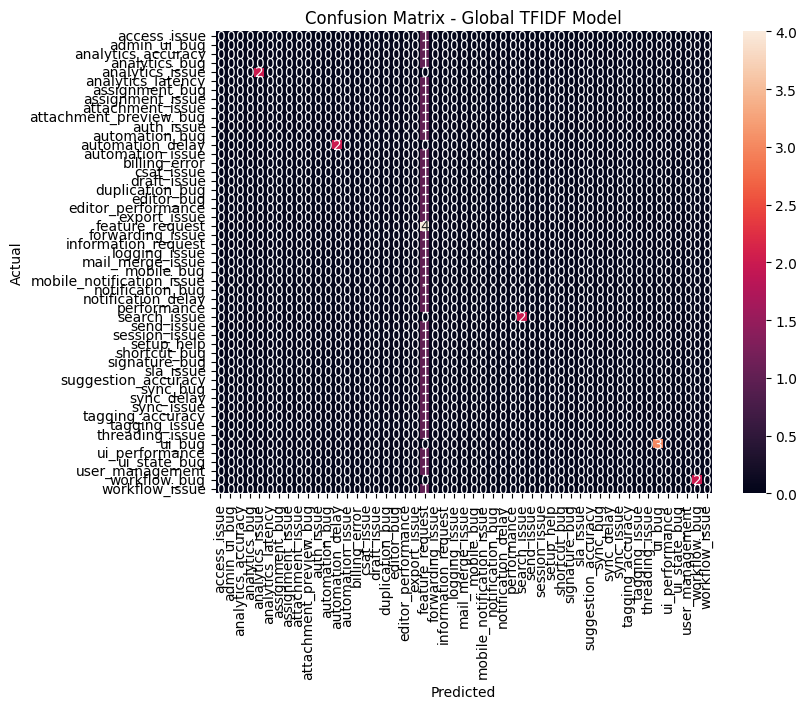

In [17]:
cm = confusion_matrix(y_test, preds, labels=global_model.named_steps['clf'].classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=global_model.named_steps['clf'].classes_,
            yticklabels=global_model.named_steps['clf'].classes_)
plt.title("Confusion Matrix - Global TFIDF Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
os.makedirs("../models", exist_ok=True)
joblib.dump(global_model, "../models/global_model.pkl")


['../models/global_model.pkl']

In [20]:
customer_models = {}
os.makedirs("../models/customers", exist_ok=True)

for cid, group in df.groupby("customer_id"):
    print(f"Training model for customer {cid}")

    if len(group) < 10:
        print(f"Skipping customer {cid} (only {len(group)} samples)")
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        group['text'], group['tag'], test_size=0.2, random_state=42
    )

    model = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2))),
        ("clf", LogisticRegression(max_iter=2000))
    ])

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    print(f"REPORT FOR CUSTOMER {cid}\n")
    print(classification_report(y_test, preds))

    joblib.dump(model, f"../models/customers/{cid}.pkl")

    customer_models[cid] = model


Training model for customer CUST_A
REPORT FOR CUSTOMER CUST_A

                  precision    recall  f1-score   support

      auth_issue       0.00      0.00      0.00       0.0
automation_delay       0.00      0.00      0.00       0.0
notification_bug       0.00      0.00      0.00       1.0
  workflow_issue       0.00      0.00      0.00       1.0

        accuracy                           0.00       2.0
       macro avg       0.00      0.00      0.00       2.0
    weighted avg       0.00      0.00      0.00       2.0

Training model for customer CUST_B
REPORT FOR CUSTOMER CUST_B

                 precision    recall  f1-score   support

analytics_issue       0.00      0.00      0.00       1.0
     mobile_bug       0.00      0.00      0.00       0.0
     sync_issue       0.00      0.00      0.00       1.0
  tagging_issue       0.00      0.00      0.00       0.0

       accuracy                           0.00       2.0
      macro avg       0.00      0.00      0.00       2.0
   wei

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [21]:
customer_allowed_tags = {
    cid: list(group['tag'].unique())
    for cid, group in df.groupby("customer_id")
}


In [23]:
def apply_guardrails(text, predicted_tag):
    text_low = text.lower()

    # Pattern 1: Billing keywords → force billing
    billing_keywords = ["charge", "charged", "invoice", "billing", "refund"]
    if any(k in text_low for k in billing_keywords):
        return "billing_issue"

    # Pattern 2: SLA rule issues → override when rule words appear
    rule_keywords = ["sla", "rule", "workflow", "automation", "auto-assign"]
    if any(k in text_low for k in rule_keywords):
        return "workflow_issue"

    # Anti-pattern: If predicted tag contradicts keywords
    if predicted_tag == "billing_issue" and "workflow" in text_low:
        return "workflow_issue"

    return predicted_tag


In [24]:
def predict_tag(customer_id, text):
    # Try customer-specific model first
    model_path = f"../models/customers/{customer_id}.pkl"
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        pred = model.predict([text])[0]
        confidence = 1.0
        source = "customer_model"
    else:
        # Use global model with filtering
        model = joblib.load("../models/global_model.pkl")
        proba = model.predict_proba([text])[0]
        classes = model.named_steps['clf'].classes_
        
        allowed = customer_allowed_tags.get(customer_id, classes.tolist())

        filtered = [
            (cls, p) for cls, p in zip(classes, proba) if cls in allowed
        ]

        pred, confidence = max(filtered, key=lambda x: x[1])
        source = "global+filtered"

    # Apply guardrail corrections
    corrected = apply_guardrails(text, pred)

    return {
        "predicted": pred,
        "corrected": corrected,
        "confidence": float(confidence),
        "source": source
    }


In [26]:
sample_text = "We are unable to configure auto assignment rules."
sample_customer = df.customer_id.iloc[0]

predict_tag(sample_customer, sample_text)


{'predicted': 'auth_issue',
 'corrected': 'workflow_issue',
 'confidence': 1.0,
 'source': 'customer_model'}